# 高斯混合模型选择

实例表明，利用信息论准则(BIC)可以对高斯混合模型进行模型选择。模型选择涉及到模型中的协方差类型和成分数。在这种情况下，AIC也提供了正确的结果(没有显示出来以节省时间)，但是如果问题是确定正确的模型，则BIC更适合。与贝叶斯程序不同的是，这种推断是无先验的。

In [1]:
# 导入必要的库
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

In [2]:
# 生成样本数据
n_samples = 300

# 生成数据
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

X

array([[ 0.68026725, -0.01634235],
       [ 3.80951844,  0.79848348],
       [-1.6613724 , -0.57766695],
       ...,
       [-5.02523709,  3.72630997],
       [-5.98684575,  2.58435579],
       [-7.40831622,  3.41279252]])

In [3]:
# 初始化BIC
lowest_bic = np.infty
bic = []

# 初始化参数
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
bic = np.array(bic)
bic

Exception in thread Thread-10 (_readerthread):
Traceback (most recent call last):
  File "d:\anaconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "d:\anaconda3\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "d:\anaconda3\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc4 in position 24: invalid continuation byte
d:\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object has no attribute 'splitlines'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line

array([5662.95617262, 4040.71759972, 3852.32785095, 3878.85812583,
       3659.60997551, 3676.39420695, 4802.56568047, 3734.78895886,
       3627.98250448, 3559.8200544 , 3365.70227982, 3363.28065779,
       5390.77453031, 3585.36756454, 3418.75444412, 3219.53514622,
       3247.87005969, 3065.05160041, 4802.56568047, 2757.51569077,
       2793.16604343, 2828.34160708, 2855.98149221, 2894.62916907])

TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

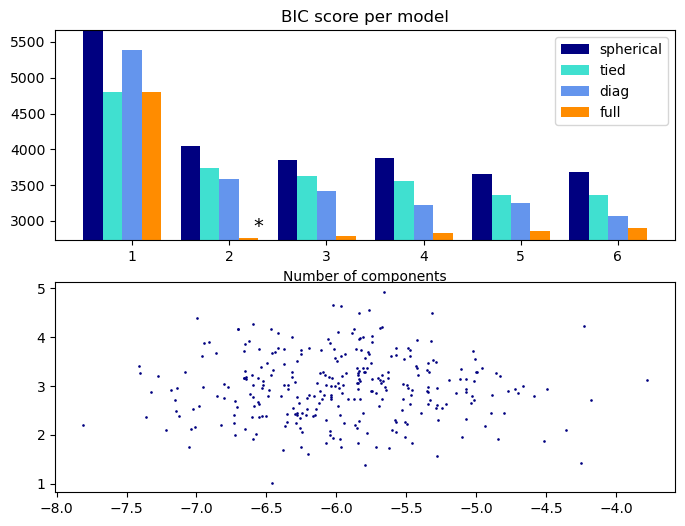

In [7]:
# 画图
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
    
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])

plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)

for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
     v, w = linalg.eigh(cov)
     if not np.any(Y_ == i):
          continue
     plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
    
     angle = np.arctan2(w[0][1], w[0][0])
     angle = 180. * angle / np.pi  # convert to degrees
     v = 2. * np.sqrt(2.) * np.sqrt(v)
     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
     ell.set_clip_box(splot.bbox)
     ell.set_alpha(.5)
     splot.add_artist(ell)
     
plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()